<a href="https://colab.research.google.com/github/marypthomas/ai-bootcamp-osu/blob/main/CSE5916_UnsupervisedML4Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

# **Unsupervised learning on handwritten digits data**

**Authors**:
- Dr. Jany Chan, The Ohio State University
- Prof. Raghu Machiraju, The Ohio State University

This tutorial is derived from the [scikit-learn demo for k-means](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py).   Instead of comparing variants of k-means, here we will compare k-means clustering with Mixture of Gaussians clustering.

The data here are a set of handwritten digits in an 8x8 format in grayscale (64-dimensional representation).  In order to be able to visualize the data, we project the 64-dimensional representation down to 2 dimensions using Principal Components Analysis (PCA).



## Load the dataset

We will start by loading the `digits` dataset. This dataset contains
handwritten digits from 0 to 9. In the context of clustering, one would like
to group images such that the handwritten digits on the image are the same.



In [ ]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


## Examine the data

Let's take a look at a few examples of the dataset, by plotting them as grayscale images.  Adjust the "item" variable to look at different examples.

label: 1


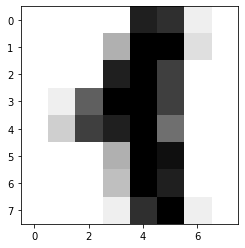

In [ ]:
import matplotlib.pyplot as plt
# look at different elements of data below
item=11
print(f"label: {labels[item]}")
plt.imshow(data[item].reshape((8,8)),cmap='binary')

## Create a 2-d reduced dimension data set and visualize

Now we'll reduce the 64-dimensional data to 2-dimensional data, and plot the distribution.

:class:`~sklearn.decomposition.PCA` allows to project the data from the
original 64-dimensional space into a lower dimensional space. Subsequently,
we can use :class:`~sklearn.decomposition.PCA` to project into a
2-dimensional space and plot the data and the clusters in this new space.

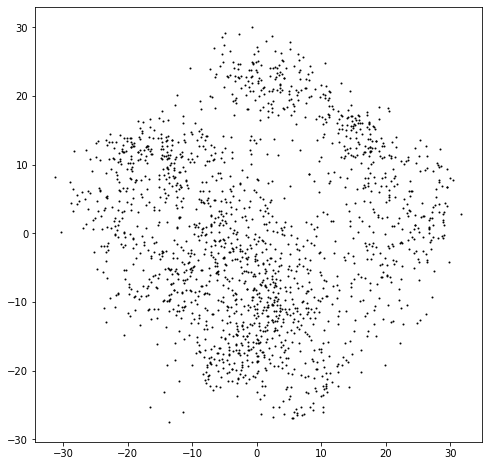

In [ ]:
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(data)

plt.figure(figsize=(8,8))
plt.plot(reduced_data[:, 0], reduced_data[:, 1], ".", color='black', markersize=2)



We can also plot some subset of the numbers to get a feeling for whether this 2-d projection preserves clusters of different kinds of numbers.

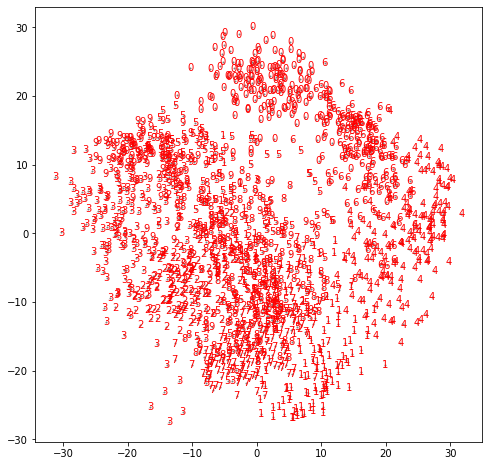

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(reduced_data[:, 0], reduced_data[:, 1], ".", color='gray', markersize=2)
# to make it easier to read the plot, change reduced_data.shape[0] to something like 250-1000
for i in range(reduced_data.shape[0]):
    plt.text(reduced_data[i,0],reduced_data[i,1],str(labels[i]),color='red',horizontalalignment='center',verticalalignment='center')
plt.show()

## K-means 

In [k-means clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans), the algorithm first chooses k different centroids, and then iteratively updates the centroids by (1) assigning each datapoint to its closest centroid, then (2) recomputing the centroid as the mean of all assigned points.  Each point belongs to one and only one centroid.  You continue until no point shifts between centroids.

The general algorithm is typically the same across all versions you run across; what matters is the initial conditions - different starting points will lead to different convergence points - so much of the cleverness is in choosing the initialization algorithm.

Since we know the number of digits (10), let's find 10 different clusters.

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data) 

KMeans(n_clusters=10, n_init=4)

Now we plot the different classification regions based on which centroid is the closest.  This is often called a tesselation, and you might also see the breaking up of the input space into different regions called "vector quantization."

The plotting technique is a pretty common one - we create a grid of x's and y's across the entire input space, and then reshape this into a set of input points.

In [ ]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
xx.shape

(2980, 3244)

In [ ]:
# this is a command that takes the matrix of xx's and yy's and reshapes it 
# into a set of points for prediction
np.c_[xx.ravel(), yy.ravel()].shape

(9667120, 2)

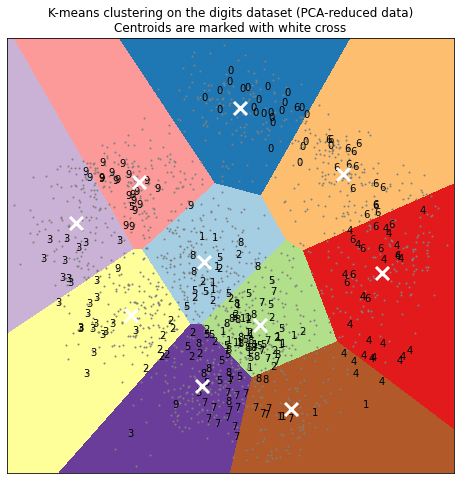

In [ ]:
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape answers back into the same shape as xx and yy
Z = Z.reshape(xx.shape)

# Put the result into a color plot
plt.figure(1,figsize=(8,8))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

# plot the points and some subset of the labels to get a feeling for the data
plt.plot(reduced_data[:, 0], reduced_data[:, 1], ".", color='gray', markersize=2)
for i in range(250):
    plt.text(reduced_data[i,0],reduced_data[i,1],str(labels[i]),color='black',horizontalalignment='center',verticalalignment='center')


# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**Question:**  do you feel that the learned boundaries correlate with the labels?  Why or why not?  (You may want to change the number of labels you display.)

## Mixture of Gaussians

Mixtures of Gaussians are *density estimators:* they compute a probability density as a combination of mutiple probability distributions, using the formula:

P(x) = sum_i  P(g_i) * G_i(x)

Where G_i is a multivariate Gaussian distribution.  We can first look at how we can estimate the density of all of the points in our dataset.

In [ ]:
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
gm = GaussianMixture(n_components=10, random_state=0, covariance_type='full').fit(reduced_data)

Let's first start by looking at the proability densities that each of the 10 Gaussians we learn assigns to a particular point, e.g. (2,2).

In [ ]:
gm.predict_proba(np.array([2,2]).reshape(1,-1))

array([[8.76578154e-01, 3.56737453e-12, 3.56601062e-08, 6.91460321e-10,
        8.44192281e-12, 8.70149448e-05, 9.38789843e-05, 9.91222552e-02,
        4.99193283e-21, 2.41186604e-02]])

**Question:** can you tell which mixture component gives the highest value?

Now we can also figure out the log likelihood of all of the input space using a contour map.  First we'll get the log likelihood over a mesh:

In [ ]:
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = -gm.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Now we plot the contour. **Question:** can you spot the 10 Gaussian means?  How can you tell?

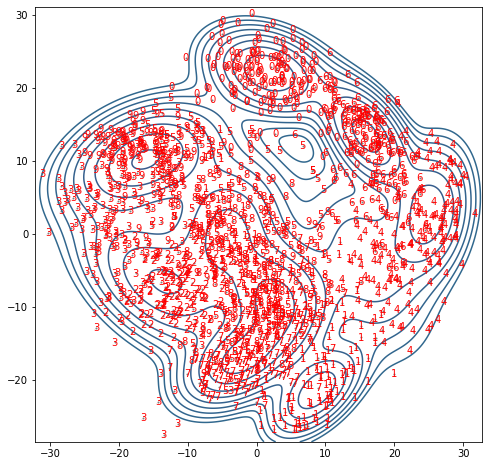

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(reduced_data[:, 0], reduced_data[:, 1], ".", color='gray', markersize=2)
for i in range(reduced_data.shape[0]):
    plt.text(reduced_data[i,0],reduced_data[i,1],str(labels[i]),color='red',horizontalalignment='center',verticalalignment='center')

CS = plt.contour(
    xx, yy, Z, norm=LogNorm(vmin=1, vmax=1000.0), levels=np.logspace(0, 1, 50)
)
plt.show()

Now we can also treat the Gaussian means like centroids, but rather than using the distance to the centroid, we use the likelihood defined by the Gaussian.

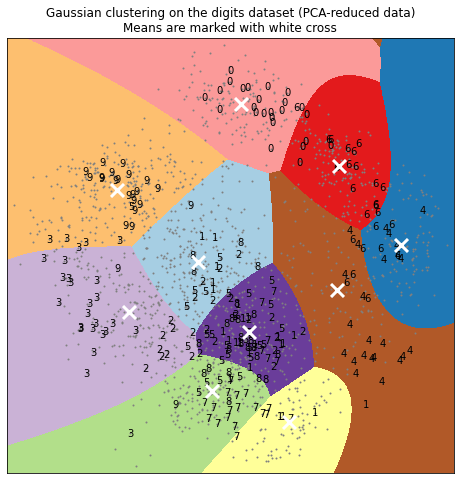

In [ ]:
# now "predict" which gaussian is "closest" by using the likelihood

Z = gm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1,figsize=(8,8))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], ".", color='gray', markersize=2)
for i in range(250):
    plt.text(reduced_data[i,0],reduced_data[i,1],str(labels[i]),color='black',horizontalalignment='center',verticalalignment='center')


# Plot the centroids as a white X
centroids = gm.means_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "Gaussian clustering on the digits dataset (PCA-reduced data)\n"
    "Means are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


**Question:** are the regions the same as with k-means?  Why?  How are they the same/different?

## Next steps

Here are some extension ideas for you to code up:

1. We didn't actually evaluate k-means or MoG as a classifier.  Unsupervised learners only group things together, not give it a label.  However, you can (sort of) classify by taking the all of the items with the same predicted k-means/MoG label, figuring out the most likely training label, and calling all items in that class the most likely label.    What is the accuracy of k-means vs. MoG?
2. We did the clustering algorithms in 2-d space because it was easy to visualize.  What happens if you cluster in the original 64-d space?  What if you project to 3-d instead of 2-d?  Try it out!

# New Section